Basic Gibbs Sampling in Python
==========================

Last week I attended the excellent [ICIC data analysis workshop 2018](https://www.imperial.ac.uk/astrophysics/centre-for-inference-and-cosmology/seminars-and-events/data-analysis-workshops/), which included some lectures on constructing Bayesian hierarchical models and fitting them to data using Gibbs sampling. Based on these lectures I put together a couple of examples, which I thought might also useful for others who are just getting started with these topics.

This notebook takes you through fitting a straight line to data using Gibbs sampling. This problem is easily tractable with traditional Markov chain Monte Carlo (MCMC), I've just used it to introduce the basic idea of Gibbs sampling and how to code it up. Because of this, it might not be immediately obvious why Gibbs sampling is useful. If you want to look at a more complex example where Gibbs sampling is necessary, take a look at the [second example]() which uses it to fit a Bayesian hierarchical model with more than a thousand free parameters.

Generating mock data
--------------------

First things first let's generate some mock data drawn from a straight line model which we can use in the rest of the example.

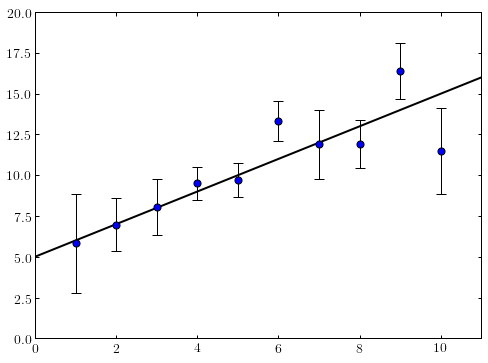

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set the minimum error for each measurement.
error_floor = 0.25

m = 1
c = 5

x_vals = np.arange(1, 11).astype(float)
y_vals = m*x_vals + c

y_errs = 1. + np.random.randn(10)**2

y_vals += y_errs*np.random.randn(10)

x = np.arange(0, 11, 0.01)

plt.figure(figsize=(8, 6))
plt.xlim(0, 11)
plt.ylim(0, 20)
plt.plot(x, m*x + c, color="black")
plt.errorbar(x_vals, y_vals, y_errs, ls="", capsize=5, color="black", lw=1)
plt.scatter(x_vals, y_vals, color="blue", lw=1, edgecolor="black", zorder=10, s=50)
plt.show()

Now imagine we have no knowledge of the input $m$ and $c$ values, only the blue mock data points we randomly generated. How would we go about fitting a straight line model $y = mx+c$ to these data with Gibbs sampling.

Setting up our model
-------------------------

First things first let's think about what we want to know. We're interested in the posterior distributions for our model parameters, $m$ and $c$ given the data, $\{y_i\}$ we just generated along with the corresponding $x$ values, $\{x_i\}$ and uncertainties $\{\sigma_i\}$. This can be written $P(m,\ c\ |\ \{y_i\})$, and can be expanded using Bayes equation to give

$P(m,\ c\ |\ \{y_i\}) = \dfrac{P(\{y_i\}|\ m,\ c)\ P(m,\ c)}{P(\{y_i\})}$.

We don't need the normalisation of this distribution to be able to sample from it, just the dependencies on our model parameters. Therefore, since our $\{y_i\}$ are fixed, we can drop the denominator to give:

$P(m,\ c\ |\ \{y_i\}) \propto P(\{y_i\}|\ m,\ c)\ P(m,\ c)$

Our uncertainties are Gaussian, so we can write down our likelihood function

$P(\{y_i\}|\ m,\ c) = \prod_i \dfrac{1}{\sqrt{2\pi\sigma_i^2}}\rm{exp}\bigg( -\dfrac{(y_i - mx_i - c)^2}{2\sigma_i^2} \bigg)$.

We also need to decide on a prior for $m$ and $c$, in this instance we'll just use uniform priors for simplicity, so

$P(m,\ c) \propto 1$.

We can now write our posterior distribution (remembering that our $\sigma_i$ are fixed, so we can drop the prefactor on the likelihood)

$P(m,\ c\ |\ \{y_i\}) \propto \rm{exp}\bigg( -\sum_i \dfrac{(y_i - mx_i - c)^2}{2\sigma_i^2} \bigg)$.

Normally we'd just throw this into a MCMC routine to obtain samples, however in this case we'll use Gibbs sampling instead

Setting up our Gibbs sampler
----------------------------------

Gibbs sampling relies on sampling from the conditional distribution for each parameter in turn, in this case these distributions are $P(m\ |\ c,\ \{y_i\})$ and $P(c\ |\ m,\ \{y_i\})$. This can be useful when it is impossible to sample from the joint distribution for all model parameters for some reason (e.g. there are a very large number of them). Most of the time this is only useful if you can write down the conditional distributions in a form which is easy to directly sample from (e.g. a Gaussian). 

First things first we need to write down our conditional distributions. We do this by treating all other model parameters as fixed. We'll continue dropping any constant factors, meaning we can get rid of any terms which don't contain the parameter we're interested in. Let's start off with $m$:

$P(m\ |\ c,\ \{y_i\}) \propto \rm{exp}\bigg( -\sum_i \dfrac{y_i^2 - m^2 x_i^2 + c^2 + 2mcx_i - 2mx_iy_i - 2cy_i}{2\sigma_i^2} \bigg) \propto \rm{exp}\bigg( -\sum_i \dfrac{m^2 x_i^2 + 2mcx_i - 2mx_iy_i}{2\sigma_i^2} \bigg)$.

We can get this into the form of a Gaussian by completing the square inside the exponential to turn our expression of the form $am^2 + bm$ into one of the form $a(m - h)^2$. The form of h is a standard result: $h = -\dfrac{b}{2a}$.

Doing this conversion results in
<br>

$h = \dfrac{\bigg(\sum_i \dfrac{x_i y_i}{\sigma_i^2} - c \sum_i \dfrac{x_i}{\sigma_i^2}\bigg)}{\sum_i \Big(\dfrac{x_i^2}{\sigma_i^2}\Big)}$
<br>

and a probability distribution of the form

$P(m\ |\ c,\ \{y_i\}) \propto \rm{exp}\Bigg( -\dfrac{1}{2} \sum_i \bigg(\dfrac{x_i^2}{\sigma_i^2}\bigg) (m - h)^2 \Bigg)$.

This is a Gaussian with mean, $\mu_m = h$ and standard deviation, $\sigma_m = \bigg(\sum_i\dfrac{x_i^2}{\sigma_i^2}\bigg)^{-\dfrac{1}{2}}$. This is very easy to sample from!

<br>

A similar set of steps for $P(c\ |\ m,\ \{y_i\})$ results in another Gaussian distribution with

$\mu_c = \dfrac{\bigg(\sum_i \dfrac{y_i}{\sigma_i^2} - m \sum_i \dfrac{x_i}{\sigma_i^2}\bigg)}{\sum_i \Big(\dfrac{1}{\sigma_i^2}\Big)}\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sigma_c = \bigg(\sum_i\dfrac{1}{\sigma_i^2}\bigg)^{-\dfrac{1}{2}}$.

<br>

We now have conditional distributions for each of our model parameters, both of which are Gaussians. Now we can start coding up our Gibbs sampler.

Coding up our Gibbs sampler
----------------------------------

First things first let's write two functions to sample from each of our conditional distributions. Each function takes a vector, param, which contains the curent values of both parameters.

In [21]:
def sample_m(param):
    
    c = param[1]
    
    mu_m_num = (np.sum(y_vals*x_vals/y_errs**2) - c*np.sum(x_vals/y_errs**2))
    inv_sigma_m_sq = np.sum(x_vals**2/y_errs**2)
    
    mu_m = mu_m_num/inv_sigma_m_sq
    sigma_m = 1./np.sqrt(inv_sigma_m_sq)
    
    return sigma_m*np.random.randn() + mu_m


def sample_c(param):

    m = param[0]

    mu_c_num = np.sum(y_vals/y_errs**2) - m*np.sum(x_vals/y_errs**2)
    inv_sigma_c_sq = np.sum(1./y_errs**2)
    
    mu_c = mu_c_num/inv_sigma_c_sq
    sigma_c = 1./np.sqrt(inv_sigma_c_sq)

    return sigma_c*np.random.randn() + mu_c

Now we're ready to sample from our joint distribution by sampling from our conditional distributions. We'll sample from each conditional distribution in turn and call this one full step of our walker. In order to increase our efficiency we'll randomise the order in which we sample our conditional distributions in each step.

In [22]:
# Number of steps we will take
n_samples = 11000

# Starting parameter values
param = np.zeros(2)

# Vectors to hold our samples
m_samp = np.zeros(n_samples)
c_samp = np.zeros(n_samples)

for i in range(1, n_samples):
    param_order = np.random.choice(np.arange(2), 2, replace=False)
    
    for k in param_order:
        if k == 0:
            m_samp[i] = sample_m(param)
            param[0] = np.copy(m_samp[i])

        else:
            c_samp[i] = sample_c(param)
            param[1] = np.copy(c_samp[i])


Let's take a look at how we did. First we'll plot the trace of the walker. The starting point is shown in blue and the true values in green.

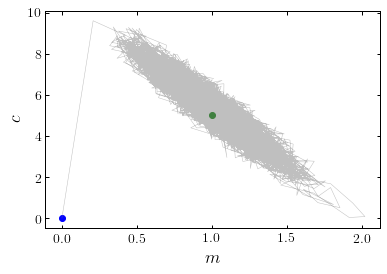

In [23]:
plt.figure()
plt.scatter(m_samp[0], c_samp[0], color="blue")
plt.scatter(m, c, color="green")
plt.plot(m_samp, c_samp, color="gray", alpha=0.5, lw=0.5)
plt.xlabel("$m$")
plt.ylabel("$c$")
plt.show()


Now the individual parameter posterior distributions, discounting the first thousand steps as a burn-in period.

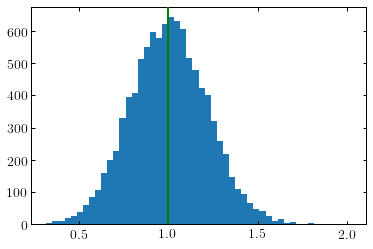

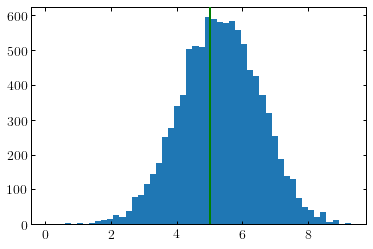

In [24]:
m_samp_burn = m_samp[1000:]
c_samp_burn = c_samp[1000:]

plt.figure()
plt.hist(m_samp_burn, bins=50)
plt.axvline(m, color="red", zorder=10)
plt.axvline(m, color="green", zorder=10)
plt.show()

plt.figure()
plt.hist(c_samp_burn, bins=50)
plt.axvline(c, color="green", zorder=10)
plt.show()

Finally let's look at the 1-sigma range for the posterior distribution of the model we fitted.

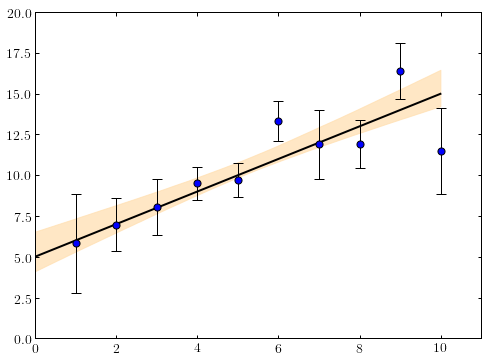

In [27]:
x = np.arange(0, 10, 0.01)

y_posterior = np.expand_dims(x, 1)*m_samp_burn + c_samp_burn

y_quantiles = np.percentile(y_posterior, (16, 84), axis=1)

plt.figure(figsize=(8, 6))
plt.xlim(0, 11)
plt.ylim(0, 20)
plt.fill_between(x, y_quantiles[0,:], y_quantiles[1,:], color="navajowhite", alpha=0.7)
plt.plot(x, m*x + c, color="black")
plt.errorbar(x_vals, y_vals, y_errs, ls="", capsize=5, color="black", lw=1)
plt.scatter(x_vals, y_vals, color="blue", lw=1, edgecolor="black", zorder=10, s=50)
plt.show()

That's how to implement a very basic Gibbs sampler. If you want to look at an example of a situation in which Gibbs sampling might be necessary to solve a problem, take a look at my [Bayesian hierarchical model example]().